In [1]:
!conda install -c conda-forge -y opencv scikit-image

Solving environment: done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - opencv
    - scikit-image


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    sqlite-3.25.2              |       hb1c47c0_0         1.6 MB  conda-forge
    hdf5-1.10.3                |       hc401514_2         4.8 MB  conda-forge
    nettle-3.3                 |                0         3.1 MB  conda-forge
    h5py-2.8.0                 |   py36h097b052_4         3.7 MB  conda-forge
    opencv-3.4.3               |py36_blas_openblash1006a3a_201        43.8 MB  conda-forge
    gnutls-3.5.19              |       h2a4e5f8_1         1.9 MB  conda-forge
    harfbuzz-1.9.0             |       h04dbb29_1         1.1 MB  conda-forge
    openh264-1.8.0             |       hd28b015_0         1.5 MB  conda-forge
    numexpr-2.6.8              |   py36hf8a1672_0

## These cells create separate images for each of the electrode pieces
Rescaling the image is often necessary to reduce memory size. The image is assumed to be rgb values in a .tif image format, and the majority of the manipulation is done with a gray scale version of the image that takes up much less memory. The first kmeans algorithm bins the pixels into either being part of the electrode or the background. Then for each contiguous area of pixels with each label we produce a new label using skimage's measure algorithm. The result is a array where each label can be selected, resulting in a True/False array for use as a mask.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(7020, 5100)


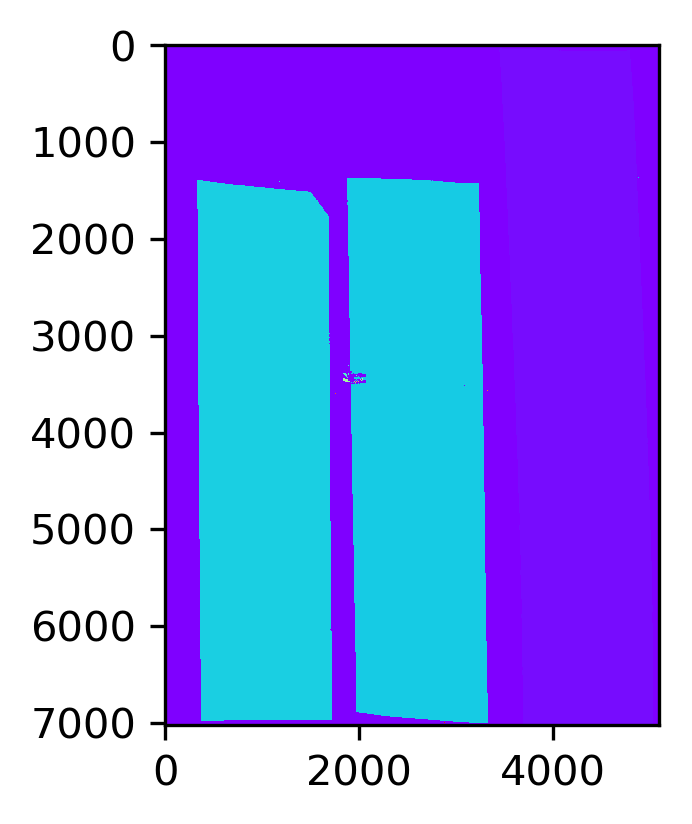

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import sklearn.cluster

from skimage import feature, io, color, measure
from skimage.transform import rescale, resize, downscale_local_mean

rescale_factor = 4.0

%matplotlib inline
# Load the image
img = io.imread('inside.tif')

# Convert the image to gray scale
im = color.rgb2gray(img)

# Rescale the image to reduce the matrix size
im = rescale(im, 1.0 / rescale_factor)
print(im.shape)

# Bin pixels with k-means into either background (white) or electrode (black)
pixels = np.reshape(im, (im.shape[0]*im.shape[1]))
labels = sklearn.cluster.KMeans(n_clusters=2, n_init=5, max_iter=20).fit_predict(pixels.reshape(-1,1))
edges1 = labels.reshape(im.shape[0], im.shape[1])

# For each of the contiguous areas of electrode produce a unique label
blobs_labels = measure.label(edges1, background=edges1[-1][-1])

# Show the map of the labels applied to each of the contiguous areas
plt.figure(figsize=(4, 3), dpi=300)
blob_img = plt.imshow(blobs_labels, cmap = 'rainbow')
del pixels
del labels
del edges1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/histograms.py:708: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


(7020, 5100, 4)
(7020, 5100, 4)
(7020, 5100, 4)
(7020, 5100, 4)
(7020, 5100, 4)


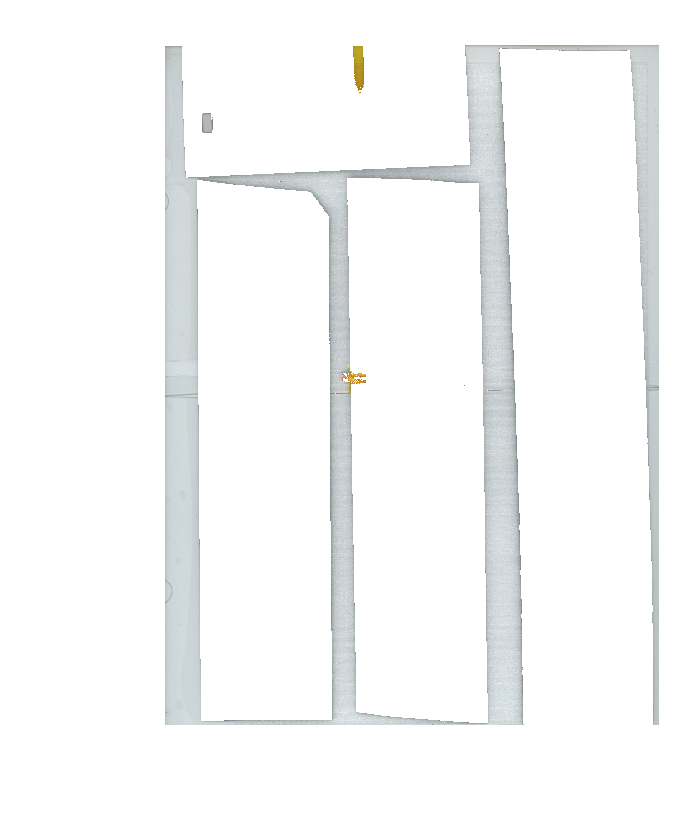

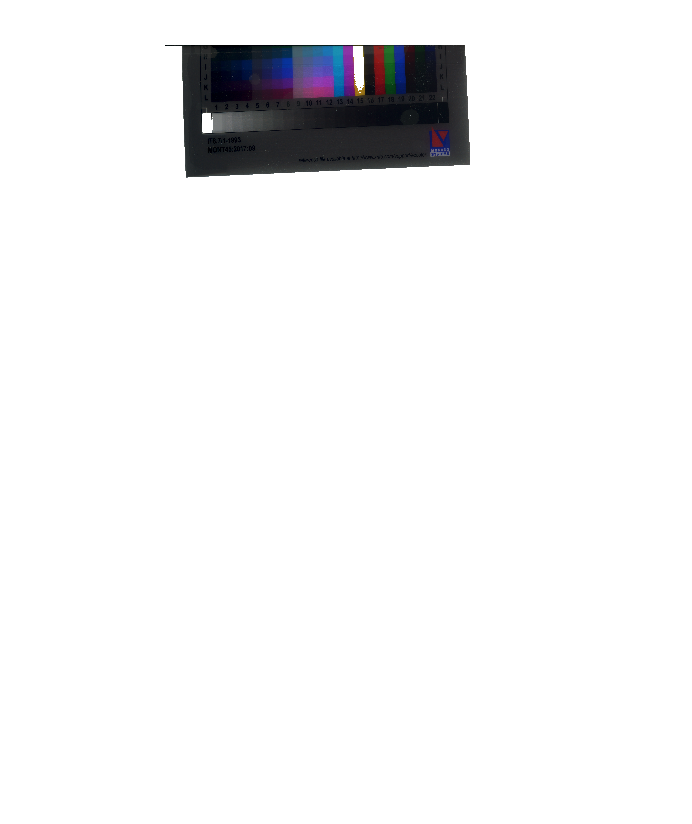

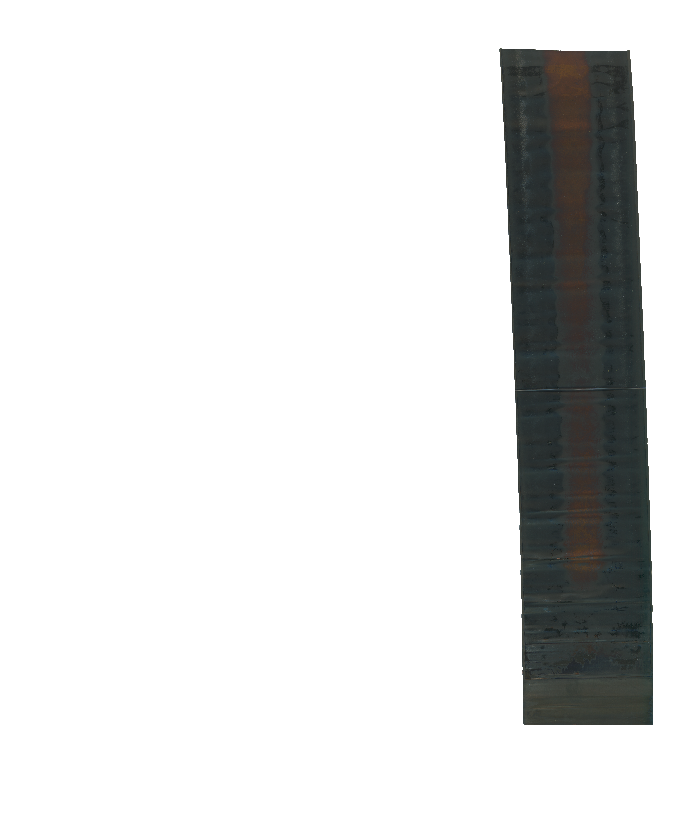

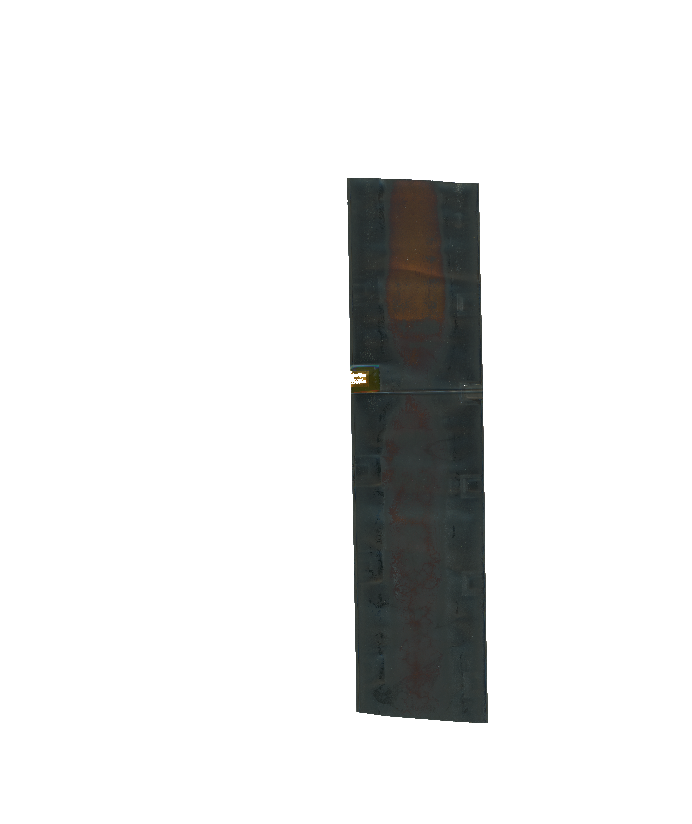

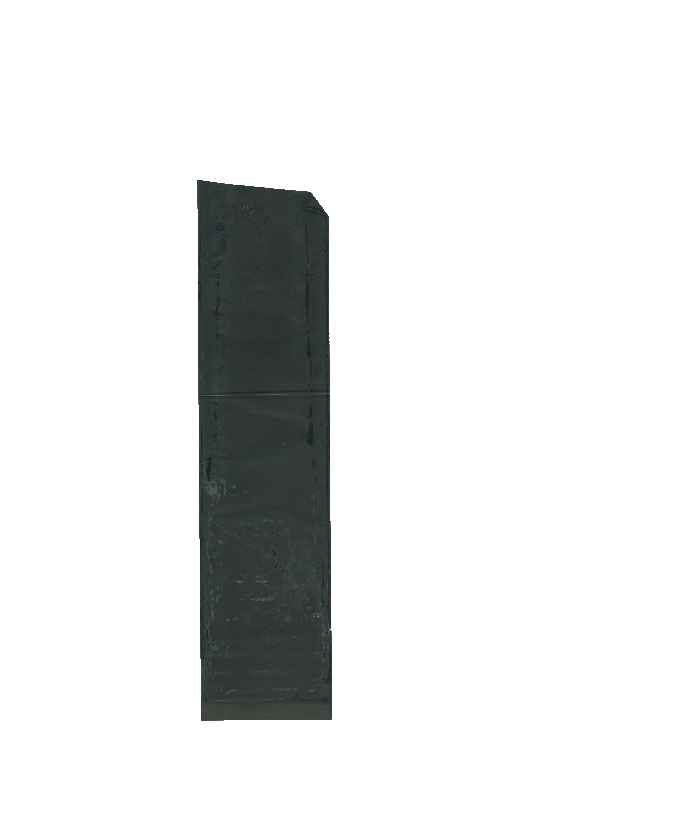

In [3]:
img_small = rescale(img, 1.0 / rescale_factor, multichannel=True)

# Get the labels that are in blobs_labels
for i in set(blobs_labels.reshape(blobs_labels.shape[0]*blobs_labels.shape[1])):
    mask = blobs_labels == i
    segment_size, _ = np.histogram(mask, bins=2)
    if segment_size[1] > 12*12*100: 
        rgb_mask = np.dstack((mask, mask, mask, mask))
        plt.figure(figsize=(4, 3), dpi=300)
        nans = np.empty((img_small.shape[0], img_small.shape[1], 3,))
        nans[:] = 1
        alpha0 = np.empty((img_small.shape[0], img_small.shape[1], 1,))
        alpha0[:] = 0
        alpha1 = np.empty((img_small.shape[0], img_small.shape[1], 1,))
        alpha1[:] = 1
        rgba = np.where(rgb_mask, np.dstack((img_small, alpha1)), np.dstack((nans, alpha0)))
        print(rgba.shape)
        blob_seg = plt.imshow(rgba)
        plt.axis('off')
        plt.savefig('im_scaled_region_{}'.format(i), transparent=True)

## This cell does pixel level k-means clustering to provide false color
Images can the colored according to clustered RGB values. This is a dynamic way of doing pixel binning, potentially for quantitative analysis something more predefined (RGB values within specific range) should be used. This is a good way of exploring how the bins should be defined.

In [ ]:
import sklearn.cluster
import sklearn.decomposition
import IPython.display
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# Load the image
img = io.imread('inside.tif')
# img = io.imread('im_scaled_region_76.png')

# Rescale the image to reduce the matrix size
im = rescale(img, 1.0 / rescale_factor, anti_aliasing=True)

plt.figure(figsize=(8, 6), dpi=300)
imgplot = plt.imshow(img)

pixels = np.reshape(im, (im.shape[0]*im.shape[1], 3))

# Perform PCA to get the primary axes of the data
pca = sklearn.decomposition.PCA(n_components=3)
pca.fit(pixels)
# Put each image along the primary axes of the data
projected = pca.transform(pixels)

# Try different clustering parameters for the data in the projected space
for i in [10, 20, 30]:
    labels = sklearn.cluster.KMeans(n_clusters=i, n_init=5, max_iter=20).fit_predict(projected)
    plt.figure(figsize=(8, 6), dpi=300)
    imgplot = plt.imshow(labels.reshape(im.shape[0], im.shape[1]))
    imgplot.set_cmap('nipy_spectral')
    plt.savefig('im_scaled_{}_clusters'.format(i))
    

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
